### Topic Modeling: Demand for Cybersecurity Professionals  

In [1]:
import pandas as pd 
import numpy as np
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#### Data Preprocessing 
Indeed Data 

In [2]:
df = pd.read_csv("C:/Users/hanna/Scape-Save-DAEN690/Datasets/indeed_cleaned.csv.gz")

In [3]:
#Remove duplicate postings if the job title, description and location are the same 
df.drop_duplicates(subset=['job_title', 'description_text', 'location'], inplace=True)

In [4]:
#Set to lower case so capitalized titles don't get counted separately
df['job_title'] = df['job_title'].apply(lambda x: str(x).lower())
#Set to lower case for job descriptions 
df['description_text'] = df['description_text'].apply(lambda x: str(x).lower())
#remove numerical values from job description
df['description_text'] = df['description_text'].str.replace('\d+', '')
#remove links from job description 
df['description_text'] = df['description_text'].str.replace('http\S+|www.\S+', '', case=False)



C:\Users\hanna\AppData\Local\Temp\ipykernel_22100\3687522721.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['description_text'] = df['description_text'].str.replace('\d+', '')
C:\Users\hanna\AppData\Local\Temp\ipykernel_22100\3687522721.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['description_text'] = df['description_text'].str.replace('http\S+|www.\S+', '', case=False)


In [5]:
#Create function to categorize role types 

def role_type(x):
    if 'lead' in x:
        return 'senior'
    elif 'senior' in x:
        return 'senior'
    elif 'sr' in x:
        return 'senior'
    elif 'chief' in x:
        return 'upper mgmt'
    elif 'manager' in x:
        return 'upper mgmt'
    elif 'principal' in x:
        return 'upper mgmt'
    elif 'junior' in x:
        return 'entry-level'
    elif 'jr' in x:
        return 'entry-level'
    elif 'entry-level' in x:
        return 'entry-level'
    elif 'entry level' in x:
        return 'entry-level'
    elif 'professor' in x: 
        return 'academia'
    else:
        return 'other'
    
df['role_type'] = df['job_title'].apply(role_type)

#Can be used for visualizations 
job_df = df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]


In [6]:
#Comparing job descriptions using cosine similarity will help remove job descriptions that are almost identical with additional word difference 
#Helps reduce processing time of the model 

corpus= df['description_text']

count_vect = CountVectorizer()

x_counts = count_vect.fit_transform(corpus)

cos_df = pd.DataFrame(cosine_similarity(x_counts))
 
i, j = np.indices(cos_df.shape).reshape(2, -1)

cos_values = cos_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'score':cos_values})

#similarity score >0.99 indicates that the job descriptions are very similar with slight variations in wordings
cos_rem = cos_sim_df[(cos_sim_df['score']>0.99)&(i!=j)]

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

#Drop rows with >0.99 similarity score from original dataframe
df = df[~df.index.isin(drop_rows)]
df = df.reset_index()
df.drop(columns={'index'}, inplace=True)

C:\Users\hanna\AppData\Local\Temp\ipykernel_22100\4223882918.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']


CareerOneStop Data

In [7]:
cos_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets//careeronestop_data.xlsx") 

In [8]:
cos_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)
#Set to lower case so capitalized titles don't get counted separately
cos_df['job_title'] = cos_df['job_title'].apply(lambda x: str(x).lower())
cos_df['description'] = cos_df['description'].apply(lambda x: str(x).lower())
#remove links from job description 
cos_df['description'] = cos_df['description'].str.replace('http\S+|www.\S+', '', case=False)

C:\Users\hanna\AppData\Local\Temp\ipykernel_22100\1830752484.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  cos_df['description'] = cos_df['description'].str.replace('http\S+|www.\S+', '', case=False)


In [9]:
#Set to lower case so capitalized titles don't get counted separately
cos_df['job_title'] = cos_df['job_title'].apply(lambda x: x.lower())
#Set to lower case for job descriptions 
cos_df['description'] = cos_df['description'].apply(lambda x: str(x).lower())
#remove numerical values from job description
cos_df['description'] = cos_df['description'].str.replace('\d+', '')

C:\Users\hanna\AppData\Local\Temp\ipykernel_22100\1223867813.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  cos_df['description'] = cos_df['description'].str.replace('\d+', '')


In [10]:
#apply function to add job roles 
cos_df['role_type'] = cos_df['job_title'].apply(role_type)

job_df = cos_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]

In [11]:
cos_df.shape

(8920, 8)

In [12]:
corpus= cos_df['description']

count_vect = CountVectorizer()

x_count_cos = count_vect.fit_transform(corpus.values.astype('U'))

cosi_df = pd.DataFrame(cosine_similarity(x_count_cos))

i, j = np.indices(cosi_df.shape).reshape(2, -1)

cos_values = cosi_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'score':cos_values})

#similarity score >0.99 indicates that the job descriptions are very similar with slight variations in wordings 
cos_rem = cos_sim_df[(cos_sim_df['score']>0.99)&(i!=j)]

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

cos_df = cos_df[~cos_df.index.isin(drop_rows)]
cos_df = cos_df.reset_index()
cos_df.drop(columns={'index'}, inplace=True)

C:\Users\hanna\AppData\Local\Temp\ipykernel_22100\3343239553.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']


#### BERTopic Algorithm

In [13]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
# ngram_range set to 2 so the topics extracted can also be 'two-words' instead of one 
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Fine-tune topic representations with 
# reduces redundacy and improve diversity of keywords using MMR 
representation_model = MaximalMarginalRelevance(0.4)

topic_model = BERTopic(
  embedding_model=embedding_model, # Step 1: Embedding        
  umap_model=umap_model, # Step 2: Dimensionality reduction                   
  hdbscan_model=hdbscan_model, # Step 3: Clustering              
  vectorizer_model=vectorizer_model, # Step 4: Tokenizer         
  ctfidf_model=ctfidf_model, # Step 5: Weighting scheme                
  representation_model=representation_model, nr_topics="auto") # Step 6: Fine-tune topic representation 

topic_model_in = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics="auto") 

In [14]:
#CareerOneStop model
topic, prob = topic_model.fit_transform(cos_df['description'].values.astype('U'))

In [15]:
#Indeed Model
topic_in, prob_in = topic_model_in.fit_transform(df['description_text'].values.astype('U')) 


In [16]:
#before topic reduction: model contains 242 topics 
topic_model.get_topic_freq()

,Topic,Count
0,0,2732
1,-1,1296
2,1,188
3,2,134
4,3,55
5,4,49
6,5,49
8,6,46
7,7,46
9,8,39


In [17]:
topic_model_in.get_topic_freq()

,Topic,Count
0,0,3247
1,-1,3094
2,1,163
3,2,52
4,3,43
...,...,...
77,76,11
78,77,11
79,78,11
80,79,11


In [18]:
#topic reduction model, reduce topic count to 50 
topic_model.reduce_topics(cos_df['description'].values.astype('U'), nr_topics=30)
topics = topic_model.topics_

In [19]:
topic_model_in.reduce_topics(df['description_text'].values.astype('U'), nr_topics=30)

In [20]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1296,-1_experience_cybersecurity_management_support
1,0,2762,0_experience_technical_management_cybersecurity
2,1,188,1_ctg_cerner millennium_healthcare_cerner secu...
3,2,134,2_rubrik_compensation range_pwc_skills experience
4,3,81,3_experience_platform_technical_solutions arch...
5,4,55,4_rubrik_salaries role_public cloud_employment
6,5,49,5_tiaa_click applicants_residing brazil_financial
7,6,46,6_litigation_foia_data_help clients
8,7,46,7_american heart_heart association_infrastruct...
9,8,39,8_directory_active directory_candidate_cbre equal


In [21]:
topic_model_in.get_topic_info()

,Topic,Count,Name
0,-1,3094,-1_experience_management_cybersecurity_risk
1,0,3557,0_experience_cybersecurity_skills_development
2,1,216,1_experience_alto networks_crowe_palo alto
3,2,198,2_teaching_umgc_student_cybersecurity
4,3,162,3_northrop grumman_employees_experience_inform...
5,4,133,4_usa remote_cloud security_experience_accenture
6,5,91,5_pscu_risk_cognizant_experience
7,6,89,6_paypal_costco_sans giac_role
8,7,72,7_experience_penetration testing_knowledge_req...
9,8,39,8_chase_health_jpmorgan chase_banking


In [22]:
#model with careeronestop data
topic_model.visualize_barchart(top_n_topics=5)

In [23]:
#model with indeed data 
topic_model_in.visualize_barchart(top_n_topics=5)

In [24]:
freq = topic_model_in.get_topic_info() 
print(freq)

    Topic  Count                                               Name
0      -1   3094        -1_experience_management_cybersecurity_risk
1       0   3557      0_experience_cybersecurity_skills_development
2       1    216         1_experience_alto networks_crowe_palo alto
3       2    198              2_teaching_umgc_student_cybersecurity
4       3    162  3_northrop grumman_employees_experience_inform...
5       4    133   4_usa remote_cloud security_experience_accenture
6       5     91                   5_pscu_risk_cognizant_experience
7       6     89                     6_paypal_costco_sans giac_role
8       7     72  7_experience_penetration testing_knowledge_req...
9       8     39              8_chase_health_jpmorgan chase_banking
10      9     36        9_deloitte_hanover_ceridian_deloitte global
11     10     35  10_experience_raytheon technologies_typically ...
12     11     34  11_network environment_internet protocol_oe_en...
13     12     34                  12_splunk_year

In [25]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1296,-1_experience_cybersecurity_management_support
1,0,2762,0_experience_technical_management_cybersecurity
2,1,188,1_ctg_cerner millennium_healthcare_cerner secu...
3,2,134,2_rubrik_compensation range_pwc_skills experience
4,3,81,3_experience_platform_technical_solutions arch...
5,4,55,4_rubrik_salaries role_public cloud_employment
6,5,49,5_tiaa_click applicants_residing brazil_financial
7,6,46,6_litigation_foia_data_help clients
8,7,46,7_american heart_heart association_infrastruct...
9,8,39,8_directory_active directory_candidate_cbre equal


In [26]:
#keywords present in our top topics 
topic_model_in.get_topic(freq.iloc[2]["Topic"])

[('experience', 0.011159264036454586),
 ('alto networks', 0.00961907741328385),
 ('crowe', 0.009522980602905776),
 ('palo alto', 0.00936241114651791),
 ('cybersecurity', 0.008491878948726448),
 ('clients', 0.008419410712678925),
 ('information', 0.008268505324575811),
 ('servicenow', 0.007324443893260484),
 ('employees', 0.006604484102427552),
 ('technical', 0.006509992041175396)]

In [28]:
#Add the topic for each record in the dataframe - CareerOneStop & Indeed Data
cos_df['topic'] = topic
df['topic_in'] = topic_in

In [29]:
#Group all keywords with a certain topic
topic_0 = cos_df[cos_df['topic'] == 0].groupby('keyword')['keyword'].count()
topic_1 = cos_df[cos_df['topic'] == 1].groupby('keyword')['keyword'].count()
topic_2 = cos_df[cos_df['topic'] == 2].groupby('keyword')['keyword'].count()
topic_3 = cos_df[cos_df['topic'] == 3].groupby('keyword')['keyword'].count()
topic_4 = cos_df[cos_df['topic'] == 4].groupby('keyword')['keyword'].count()

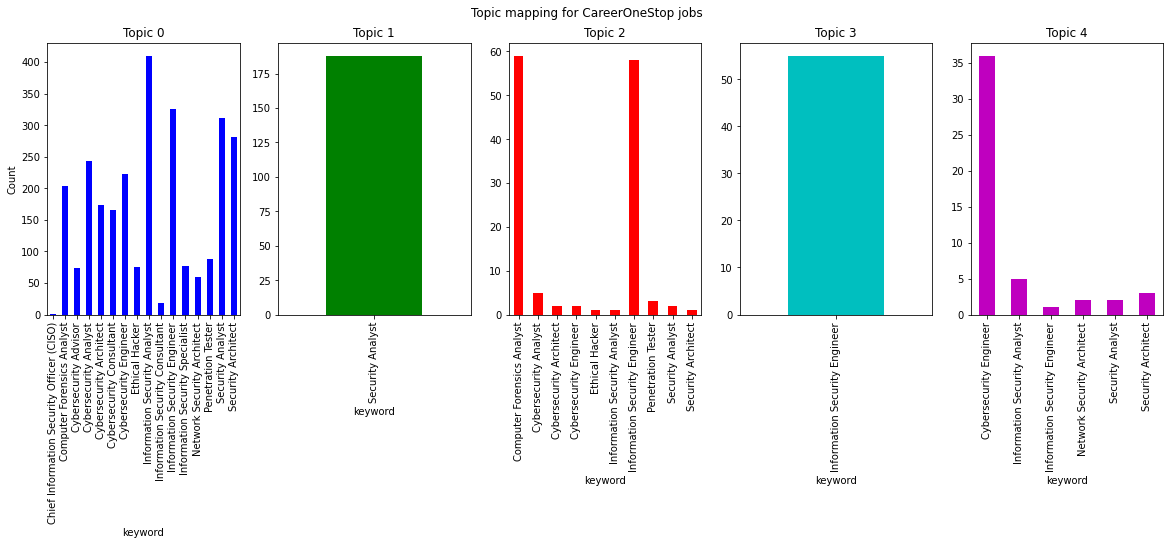

In [30]:
#Barplots showing the job families for each topic
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# plot each series on a different subplot
topic_0.plot.bar(ax=axs[0], color='b')
topic_1.plot.bar(ax=axs[1], color='g')
topic_2.plot.bar(ax=axs[2], color='r')
topic_3.plot.bar(ax=axs[3], color='c')
topic_4.plot.bar(ax=axs[4], color='m')

# set titles and labels for each subplot
axs[0].set_title('Topic 0')
axs[1].set_title('Topic 1')
axs[2].set_title('Topic 2')
axs[3].set_title('Topic 3')
axs[4].set_title('Topic 4')
axs[0].set_ylabel('Count')


# set a title for the figure
fig.suptitle('Topic mapping for CareerOneStop jobs')

# display the plot
plt.show()